In [1]:
import pandas as pd
import os

def load_datasets(base_path='e:\\SEMESTER 5\\DEEP LEARNING\\FINAL\\neurips-open-polymer-prediction-2025'):
    """
    Load all datasets from the project directory.
    
    Parameters:
    -----------
    base_path : str
        Base path to the project directory
        
    Returns:
    --------
    dict : Dictionary containing all loaded datasets
    """
    datasets = {}
    
    # Load main train dataset
    train_path = os.path.join(base_path, 'train.csv')
    datasets['train'] = pd.read_csv(train_path)
    # Load main test dataset
    test_path = os.path.join(base_path, 'test.csv')
    datasets['test'] = pd.read_csv(test_path)
    
    # Load supplementary datasets
    supplement_path = os.path.join(base_path, 'train_supplement')
    for i in range(1, 5):
        dataset_path = os.path.join(supplement_path, f'dataset{i}.csv')
        datasets[f'dataset{i}'] = pd.read_csv(dataset_path)
    
    return datasets


data = load_datasets()
test_df = data['test']
train_df = data['train']
dataset1_df = data['dataset1']
dataset2_df = data['dataset2']
dataset3_df = data['dataset3']
dataset4_df = data['dataset4']

In [2]:
from rdkit import Chem 
from rdkit.Chem import AllChem 
from rdkit.Chem.rdmolops import RemoveHs

def safe_mol_from_smiles(smiles):
    if pd.isna(smiles) or not isinstance(smiles, str) or smiles.strip() == '':
        return None
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except:
        return None
    
def largest_fragment(mol):
    frags = Chem.GetMolFrags(mol, asMols=True)
    if len(frags) == 1:
        return mol
    largest = max(frags, key=lambda m: m.GetNumAtoms())
    return largest

def neutralize_molecule(mol):
    try:
        # RDKit built-in neutralization
        uncharger = Chem.rdMolStandardize.Uncharger()
        mol = uncharger.uncharge(mol)
        return mol
    except:
        return mol
    
def canonicalize(mol):
    try:
        return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None
    
    
def sanitize_smiles_pipeline(smiles):
    # Step 1: Safe Mol
    mol = safe_mol_from_smiles(smiles)
    if mol is None:
        return None

    # Step 2: Remove salts
    mol = largest_fragment(mol)

    # Step 3: Neutralize
    mol = neutralize_molecule(mol)

    # Step 4: Re-sanitize
    try:
        Chem.SanitizeMol(mol)
    except:
        return None

    # Step 5: Canonicalize
    return canonicalize(mol)

In [3]:
# Replace your validate_smiles_entries call with this:

def validate_smiles_entries_dict(dfs_dict, smiles_column="SMILES"):
    """
    SMILES validation using explicit dictionary keys.
    """
    results = {}

    for df_name, df in dfs_dict.items():
        df_copy = df.copy()

        canonical_list = []
        errors = []

        for s in df_copy[smiles_column]:
            try:
                mol = Chem.MolFromSmiles(s, sanitize=True)
                if mol is None:
                    canonical_list.append(None)
                    errors.append({"SMILES": s, "error": "MolFromSmiles returned None"})
                else:
                    canon = Chem.MolToSmiles(mol, canonical=True)
                    canonical_list.append(canon)
                    errors.append(None)
            except Exception as e:
                canonical_list.append(None)
                errors.append({"SMILES": s, "error": str(e)})

        df_copy["canonical_SMILES"] = canonical_list
        df_copy["sanitization_error"] = errors

        # Summary QC
        total = len(df_copy)
        valid = df_copy["canonical_SMILES"].notna().sum()
        invalid = total - valid
        unique_raw = df_copy[smiles_column].nunique()
        unique_canon = df_copy["canonical_SMILES"].nunique()

        print("\n=====================================")
        print(f"🔎 QC for {df_name}")
        print("=====================================")
        print(f"Total entries:                  {total}")
        print(f"Valid sanitized molecules:      {valid}")
        print(f"Invalid molecules:              {invalid}")
        print(f"Raw unique SMILES:              {unique_raw}")
        print(f"Canonical unique SMILES:        {unique_canon}")
        print(f"Duplicates lost after cleaning: {unique_raw - unique_canon}")
        print("-------------------------------------")

        invalid_df = df_copy[df_copy["canonical_SMILES"].isna()]
        if len(invalid_df) > 0:
            print("❌ Invalid molecules found:")
            print(invalid_df[[smiles_column, "sanitization_error"]].head())
        else:
            print("✅ No invalid molecules.")

        results[df_name] = {
            "clean_df": df_copy[df_copy["canonical_SMILES"].notna()].copy(),
            "invalid_df": invalid_df.copy(),
            "full_df": df_copy,
        }

    return results

# Use explicit dictionary with names
checklist = {
    'test_df': test_df,
    'train_df': train_df,
    'dataset1_df': dataset1_df,
    'dataset2_df': dataset2_df,
    'dataset3_df': dataset3_df,
    'dataset4_df': dataset4_df
}

qc_results = validate_smiles_entries_dict(checklist)

# Now extract cleaned DataFrames
train_df = qc_results['train_df']['clean_df']
dataset1_df = qc_results['dataset1_df']['clean_df']
dataset2_df = qc_results['dataset2_df']['clean_df']
dataset3_df = qc_results['dataset3_df']['clean_df']
dataset4_df = qc_results['dataset4_df']['clean_df']
test_df = qc_results['test_df']['clean_df']


🔎 QC for test_df
Total entries:                  3
Valid sanitized molecules:      3
Invalid molecules:              0
Raw unique SMILES:              3
Canonical unique SMILES:        3
Duplicates lost after cleaning: 0
-------------------------------------
✅ No invalid molecules.

🔎 QC for train_df
Total entries:                  7973
Valid sanitized molecules:      7973
Invalid molecules:              0
Raw unique SMILES:              7973
Canonical unique SMILES:        7973
Duplicates lost after cleaning: 0
-------------------------------------
✅ No invalid molecules.

🔎 QC for dataset1_df
Total entries:                  874
Valid sanitized molecules:      874
Invalid molecules:              0
Raw unique SMILES:              867
Canonical unique SMILES:        866
Duplicates lost after cleaning: 1
-------------------------------------
✅ No invalid molecules.

🔎 QC for dataset2_df
Total entries:                  7208
Valid sanitized molecules:      7208
Invalid molecules:         

In [19]:
from functools import reduce

def prepare_for_merge(df, key="canonical_SMILES"):
    """Remove duplicate SMILES and prepare for merge."""
    df = df.copy()
    
    # Drop raw SMILES if canonical exists
    if "SMILES" in df.columns and key != "SMILES":
        df = df.drop(columns=["SMILES"])

    # Drop duplicate key rows
    before = len(df)
    df = df.drop_duplicates(subset=[key])
    after = len(df)

    print(f"[Prepare] Rows before={before}, after deduplicate={after}")
    return df


def smart_outer_merge_with_analysis(base_df, supplement_dfs, key="canonical_SMILES"):
    """
    OUTER merge strategy for handling:
    - Base dataset with complete targets
    - Supplement datasets with NEW molecules (sparse targets)
    - Filling overlapping targets where possible
    """
    base_df = prepare_for_merge(base_df, key=key)
    target_columns = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    
    print("\n" + "="*70)
    print("📊 BASE DATASET ANALYSIS")
    print("="*70)
    print(f"Base molecules: {len(base_df)}")
    print(f"\nTarget coverage in base:")
    for col in target_columns:
        if col in base_df.columns:
            available = base_df[col].notna().sum()
            pct = (available / len(base_df)) * 100
            print(f"  {col:10s}: {available:6d} / {len(base_df):6d} ({pct:5.1f}%)")
    
    # Start with base
    merged = base_df.copy()
    base_molecules = set(base_df[key])
    
    # Track statistics
    new_molecules_added = 0
    target_fills_per_supplement = []
    
    print("\n" + "="*70)
    print("📦 MERGING SUPPLEMENT DATASETS")
    print("="*70)
    
    for i, supp_df in enumerate(supplement_dfs, 1):
        supp_df = prepare_for_merge(supp_df, key=key)
        
        # Identify new molecules
        supp_molecules = set(supp_df[key])
        new_in_supp = supp_molecules - base_molecules
        overlap_with_base = supp_molecules & base_molecules
        
        print(f"\n  Dataset {i}:")
        print(f"    Total molecules:      {len(supp_df)}")
        print(f"    New molecules:        {len(new_in_supp)}")
        print(f"    Overlap with base:    {len(overlap_with_base)}")
        
        # Count targets in supplement
        supp_targets = {}
        for col in target_columns:
            if col in supp_df.columns:
                count = supp_df[col].notna().sum()
                supp_targets[col] = count
                print(f"      {col:10s}: {count:6d} values")
        
        # Count targets BEFORE merge
        targets_before = {}
        for col in target_columns:
            if col in merged.columns:
                targets_before[col] = merged[col].notna().sum()
        
        # OUTER MERGE
        merged = merged.merge(
            supp_df,
            on=key,
            how="outer",  # ← Keep all molecules from both
            suffixes=("", f"_supp{i}")
        )
        
        # Coalesce: Fill base NaN with supplement values
        fills_made = {}
        for col in target_columns:
            dup_col = f"{col}_supp{i}"
            if dup_col in merged.columns:
                # Count how many fills we'll make
                before_fill = merged[col].notna().sum() if col in merged.columns else 0
                
                # Fill strategy: base column takes priority
                if col not in merged.columns:
                    merged[col] = merged[dup_col]
                else:
                    merged[col] = merged[col].fillna(merged[dup_col])
                
                after_fill = merged[col].notna().sum()
                fills_made[col] = after_fill - before_fill
                
                # Drop duplicate column
                merged = merged.drop(columns=[dup_col])
        
        # Count targets AFTER merge
        print(f"    Targets filled:")
        for col, count in fills_made.items():
            if count > 0:
                print(f"      {col:10s}: +{count:6d} values")
        
        # Update tracking
        new_molecules_added += len(new_in_supp)
        base_molecules.update(supp_molecules)
    
    print("\n" + "="*70)
    print("✅ MERGE COMPLETE")
    print("="*70)
    print(f"Base molecules:        {len(base_df)}")
    print(f"New molecules added:   {new_molecules_added}")
    print(f"Total molecules:       {len(merged)}")
    
    print(f"\n📊 Final target coverage:")
    for col in target_columns:
        if col in merged.columns:
            available = merged[col].notna().sum()
            pct = (available / len(merged)) * 100
            print(f"  {col:10s}: {available:6d} / {len(merged):6d} ({pct:5.1f}%)")
    
    return merged


# ============================================================
# EXECUTE MERGE
# ============================================================
print("\n" + "="*70)
print("🔗 MERGING STRATEGY: OUTER JOIN WITH SPARSE TARGET HANDLING")
print("="*70)

df_augmented = smart_outer_merge_with_analysis(
    base_df=train_df,
    supplement_dfs=[dataset1_df, dataset2_df, dataset3_df, dataset4_df]
)

# ============================================================
# QUALITY FILTER (OPTIONAL)
# ============================================================
print("\n" + "="*70)
print("🔍 DATA QUALITY ANALYSIS")
print("="*70)

target_columns = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
target_counts = df_augmented[target_columns].notna().sum(axis=1)

print(f"\nMolecules by target availability:")
for i in range(6):
    count = (target_counts == i).sum()
    pct = (count / len(df_augmented)) * 100
    status = "❌ USELESS" if i == 0 else "⚠️  SPARSE" if i < 3 else "✅ GOOD"
    print(f"  {i} targets: {count:6d} molecules ({pct:5.1f}%)  {status}")

# OPTIONAL: Remove molecules with NO targets
before_filter = len(df_augmented)
df_augmented = df_augmented[target_counts > 0].copy()
after_filter = len(df_augmented)

print(f"\n🗑️  Removed {before_filter - after_filter} molecules with 0 targets")
print(f"✅ Final dataset: {after_filter} molecules")

# OPTIONAL: Stricter filter (≥2 targets)
# Uncomment if you want higher quality:
# df_augmented = df_augmented[df_augmented[target_columns].notna().sum(axis=1) >= 2].copy()
# print(f"✅ Filtered to molecules with ≥2 targets: {len(df_augmented)}")

# ============================================================
# CLEAN UP
# ============================================================
df_augmented = df_augmented.drop(columns=["sanitization_error", "id"], errors='ignore')

print(f"\n" + "="*70)
print(f"✅ FINAL AUGMENTED DATASET")
print(f"="*70)
print(f"Total molecules: {len(df_augmented)}")
print(f"\n📊 Final target distribution:")

target_counts_final = df_augmented[target_columns].notna().sum(axis=1)
for col in target_columns:
    available = df_augmented[col].notna().sum()
    pct = (available / len(df_augmented)) * 100
    print(f"  {col:10s}: {available:6d} / {len(df_augmented):6d} ({pct:5.1f}%)")

# Display
df_augmented


🔗 MERGING STRATEGY: OUTER JOIN WITH SPARSE TARGET HANDLING
[Prepare] Rows before=7973, after deduplicate=7973

📊 BASE DATASET ANALYSIS
Base molecules: 7973

Target coverage in base:
  Tg        :    511 /   7973 (  6.4%)
  FFV       :   7030 /   7973 ( 88.2%)
  Tc        :    737 /   7973 (  9.2%)
  Density   :    613 /   7973 (  7.7%)
  Rg        :    614 /   7973 (  7.7%)

📦 MERGING SUPPLEMENT DATASETS
[Prepare] Rows before=874, after deduplicate=866

  Dataset 1:
    Total molecules:      866
    New molecules:        129
    Overlap with base:    737
    Targets filled:
[Prepare] Rows before=7208, after deduplicate=7174

  Dataset 2:
    Total molecules:      7174
    New molecules:        1923
    Overlap with base:    5251
    Targets filled:
[Prepare] Rows before=46, after deduplicate=46

  Dataset 3:
    Total molecules:      46
    New molecules:        46
    Overlap with base:    0
      Tg        :     46 values
    Targets filled:
      Tg        : +    46 values
[Prepare

,Tg,FFV,Tc,Density,Rg,canonical_SMILES,TC_mean,sanitization_error_supp1,sanitization_error_supp2,sanitization_error_supp3,sanitization_error_supp4
7,206.5699,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccccc1)c1ccccc1,NaN,NaN,NaN,NaN,NaN
49,NaN,NaN,0.1020,NaN,NaN,*/C(F)=C(\F)C(F)(C(*)(F)F)C(F)(F)F,0.1020,None,None,NaN,NaN
51,NaN,NaN,0.4105,0.8857,15.0640,*/C=C(/*)C#CCCCCCCCCCCCCCCCCCCCCC(=O)O,0.4105,None,NaN,NaN,NaN
57,NaN,NaN,0.4030,0.8685,14.0786,*/C=C(/*)CCCCCCCCCCCCCCCCCCCCC(=O)O,0.4030,None,NaN,NaN,NaN
74,243.9893,NaN,NaN,NaN,NaN,*/C=C(\C#N)C(=O)Nc1cccc(NC(=O)/C(C#N)=C/c2ccc(...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10336,NaN,NaN,0.3787,0.9494,16.1137,*c1sc(*)c(OCCCCCCCCCCCC)c1C,0.3787,None,NaN,NaN,NaN
10337,NaN,NaN,0.4368,0.9443,14.8441,*c1sc(*)c(OCCCCCCCCCCCCCC)c1C,0.4368,None,NaN,NaN,NaN
10338,NaN,NaN,0.3880,NaN,NaN,*c1sc(*)c(OCCCCCCCCCCCCCCCC)c1C,0.3880,None,NaN,NaN,NaN
10339,NaN,NaN,0.3747,0.9044,14.3483,*c1sc(*)c(OCCCCCCCCCCCCCCCCCCCC)c1C,0.3747,None,NaN,NaN,NaN


In [20]:
# ============================================================
# QUALITY FILTER: Keep ONLY molecules with ≥3 targets
# ============================================================
print("\n" + "="*70)
print("🔍 AGGRESSIVE QUALITY FILTERING")
print("="*70)

target_columns = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
target_counts = df_augmented[target_columns].notna().sum(axis=1)

# Show distribution BEFORE filtering
print(f"\n📊 BEFORE FILTERING:")
print(f"Total molecules: {len(df_augmented)}")
print(f"\nMolecules by target availability:")
for i in range(6):
    count = (target_counts == i).sum()
    pct = (count / len(df_augmented)) * 100
    status = "❌ REMOVE" if i < 3 else "✅ KEEP"
    print(f"  {i} targets: {count:6d} molecules ({pct:5.1f}%)  {status}")

# Apply AGGRESSIVE filter: Keep only molecules with ≥2 targets
before_filter = len(df_augmented)
df_filtered = df_augmented[target_counts >= 2].copy()
after_filter = len(df_filtered)

removed = before_filter - after_filter
removed_pct = (removed / before_filter) * 100

print(f"\n🗑️  Removed {removed:,} molecules ({removed_pct:.1f}%)")
print(f"✅ Kept {after_filter:,} high-quality molecules")

# Replace df_augmented with filtered version
df_augmented = df_filtered

# Recompute target counts for remaining molecules
target_counts_final = df_augmented[target_columns].notna().sum(axis=1)

print(f"\n📊 AFTER FILTERING:")
print(f"Total molecules: {len(df_augmented)}")
print(f"\nMolecules by target availability:")
for i in range(6):
    count = (target_counts_final == i).sum()
    pct = (count / len(df_augmented)) * 100 if len(df_augmented) > 0 else 0
    print(f"  {i} targets: {count:6d} molecules ({pct:5.1f}%)")

print(f"\n📊 Final target coverage:")
for col in target_columns:
    available = df_augmented[col].notna().sum()
    total = len(df_augmented)
    pct = (available / total) * 100 if total > 0 else 0
    missing = total - available
    print(f"  {col:10s}: {available:6d} / {total:6d} ({pct:5.1f}%)  [Missing: {missing:6d}]")

# Compute average targets per molecule
if len(df_augmented) > 0:
    avg_targets = df_augmented[target_columns].notna().sum(axis=1).mean()
    print(f"\n📈 Average targets per molecule: {avg_targets:.2f}")
else:
    print(f"\n⚠️  WARNING: No molecules left after filtering!")

# ============================================================
# CLEAN UP
# ============================================================
df_augmented = df_augmented.drop(columns=["sanitization_error", "id"], errors='ignore')

print(f"\n" + "="*70)
print(f"✅ FINAL FILTERED DATASET")
print(f"="*70)
print(f"Total molecules: {len(df_augmented):,}")

if len(df_augmented) > 0:
    print(f"\n🎯 Quality Metrics:")
    print(f"  • Removed sparse molecules: {removed:,} ({removed_pct:.1f}%)")
    print(f"  • Kept high-quality data:   {after_filter:,} ({(1-removed_pct/100)*100:.1f}%)")
    print(f"  • Average targets/molecule: {avg_targets:.2f}")
    print(f"  • Min targets/molecule:     3")
    
    # Check if we have enough data
    if len(df_augmented) < 100:
        print(f"\n⚠️  WARNING: Very small dataset ({len(df_augmented)} molecules)")
        print(f"   Consider using ≥2 targets filter instead")
else:
    print(f"\n❌ ERROR: No molecules remaining!")
    print(f"   Your base dataset quality is too poor.")
    print(f"   Recommendation: Check data source or use ≥2 targets filter")

# Display
df_augmented


🔍 AGGRESSIVE QUALITY FILTERING

📊 BEFORE FILTERING:
Total molecules: 8881

Molecules by target availability:
  0 targets:      0 molecules (  0.0%)  ❌ REMOVE
  1 targets:   8174 molecules ( 92.0%)  ❌ REMOVE
  2 targets:    122 molecules (  1.4%)  ❌ REMOVE
  3 targets:    345 molecules (  3.9%)  ✅ KEEP
  4 targets:    240 molecules (  2.7%)  ✅ KEEP
  5 targets:      0 molecules (  0.0%)  ✅ KEEP

🗑️  Removed 8,174 molecules (92.0%)
✅ Kept 707 high-quality molecules

📊 AFTER FILTERING:
Total molecules: 707

Molecules by target availability:
  0 targets:      0 molecules (  0.0%)
  1 targets:      0 molecules (  0.0%)
  2 targets:    122 molecules ( 17.3%)
  3 targets:    345 molecules ( 48.8%)
  4 targets:    240 molecules ( 33.9%)
  5 targets:      0 molecules (  0.0%)

📊 Final target coverage:
  Tg        :     38 /    707 (  5.4%)  [Missing:    669]
  FFV       :    349 /    707 ( 49.4%)  [Missing:    358]
  Tc        :    627 /    707 ( 88.7%)  [Missing:     80]
  Density   :    611 

,Tg,FFV,Tc,Density,Rg,canonical_SMILES,TC_mean,sanitization_error_supp1,sanitization_error_supp2,sanitization_error_supp3,sanitization_error_supp4
51,NaN,NaN,0.4105,0.8857,15.0640,*/C=C(/*)C#CCCCCCCCCCCCCCCCCCCCCC(=O)O,0.4105,None,NaN,NaN,NaN
57,NaN,NaN,0.4030,0.8685,14.0786,*/C=C(/*)CCCCCCCCCCCCCCCCCCCCC(=O)O,0.4030,None,NaN,NaN,NaN
84,59.5588,NaN,0.3940,0.7750,34.6729,*/C=C/*,0.5260,None,None,NaN,NaN
87,NaN,NaN,NaN,0.9719,13.1015,*/C=C/C(C(=O)OC(C)C)C(*)C(=O)OC(C)C,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,NaN,0.8207,15.5065,*/C=C/C(C)(C)C(*)(C)C,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10321,NaN,NaN,0.3647,0.9925,22.5717,*c1nc2cc3sc(-c4cc(OCCCCCCCCCCCC)c(*)cc4OCCCCCC...,0.3647,None,NaN,NaN,NaN
10336,NaN,NaN,0.3787,0.9494,16.1137,*c1sc(*)c(OCCCCCCCCCCCC)c1C,0.3787,None,NaN,NaN,NaN
10337,NaN,NaN,0.4368,0.9443,14.8441,*c1sc(*)c(OCCCCCCCCCCCCCC)c1C,0.4368,None,NaN,NaN,NaN
10339,NaN,NaN,0.3747,0.9044,14.3483,*c1sc(*)c(OCCCCCCCCCCCCCCCCCCCC)c1C,0.3747,None,NaN,NaN,NaN


In [21]:
# Identify available columns
print("\n" + "="*60)
print("📊 AVAILABLE FEATURES IN AUGMENTED DATA")
print("="*60)

print("\nAll columns:")
print(df_augmented.columns.tolist())

# Define target columns (these are what we predict)
target_columns = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Get ALL numerical columns EXCEPT canonical_SMILES
# This includes target columns (they have numerical data too!)
numerical_columns = []
for col in df_augmented.columns:
    if col != 'canonical_SMILES':  # Only exclude SMILES identifier
        # Check if column is numeric (robust check)
        if pd.api.types.is_numeric_dtype(df_augmented[col]):
            numerical_columns.append(col)

print(f"\n📋 Target columns ({len(target_columns)}):")
for col in target_columns:
    print(f"   - {col}")

print(f"\n🔢 ALL Numerical feature columns ({len(numerical_columns)}):")
for col in numerical_columns:
    is_target = "⭐ TARGET" if col in target_columns else ""
    print(f"   - {col:20s} {is_target}")

if len(numerical_columns) > 0:
    print(f"\n📊 Feature coverage (including NaN values):")
    for col in numerical_columns:
        available = df_augmented[col].notna().sum()
        total = len(df_augmented)
        pct = (available / total) * 100
        is_target = "[TARGET]" if col in target_columns else "[FEATURE]"
        print(f"  {is_target:10s} {col:20s}: {available:6d} / {total:6d} ({pct:5.1f}%)")
    
    # Count non-target features
    non_target_features = [col for col in numerical_columns if col not in target_columns]
    
    print("\n" + "="*60)
    print(f"✅ Combined features for XGBoost:")
    print(f"   - GNN embeddings:      32 dimensions")
    print(f"   - Target columns:      {len(target_columns)} dimensions (will be used as features)")
    if len(non_target_features) > 0:
        print(f"   - Other numerical:     {len(non_target_features)} dimensions")
        print(f"   - TOTAL:              {32 + len(numerical_columns)} dimensions")
    else:
        print(f"   - TOTAL:              {32 + len(target_columns)} dimensions")
    print("="*60)
    
    print(f"\n⚠️  NOTE: Target columns with available values will be used as features")
    print(f"   Missing target values (NaN) will be filled with 0")
else:
    print("\n⚠️ No numerical features found!")
    print("   Will use GNN embeddings only (32 dimensions)")


📊 AVAILABLE FEATURES IN AUGMENTED DATA

All columns:
['Tg', 'FFV', 'Tc', 'Density', 'Rg', 'canonical_SMILES', 'TC_mean', 'sanitization_error_supp1', 'sanitization_error_supp2', 'sanitization_error_supp3', 'sanitization_error_supp4']

📋 Target columns (5):
   - Tg
   - FFV
   - Tc
   - Density
   - Rg

🔢 ALL Numerical feature columns (6):
   - Tg                   ⭐ TARGET
   - FFV                  ⭐ TARGET
   - Tc                   ⭐ TARGET
   - Density              ⭐ TARGET
   - Rg                   ⭐ TARGET
   - TC_mean              

📊 Feature coverage (including NaN values):
  [TARGET]   Tg                  :     38 /    707 (  5.4%)
  [TARGET]   FFV                 :    349 /    707 ( 49.4%)
  [TARGET]   Tc                  :    627 /    707 ( 88.7%)
  [TARGET]   Density             :    611 /    707 ( 86.4%)
  [TARGET]   Rg                  :    614 /    707 ( 86.8%)
  [FEATURE]  TC_mean             :    627 /    707 ( 88.7%)

✅ Combined features for XGBoost:
   - GNN embeddings

In [23]:
df_augmented = df_augmented.drop(columns=['sanitization_error_supp1', 'sanitization_error_supp2', 'sanitization_error_supp3', 'sanitization_error_supp4'], errors='ignore')
df_augmented

,Tg,FFV,Tc,Density,Rg,canonical_SMILES,TC_mean
51,NaN,NaN,0.4105,0.8857,15.0640,*/C=C(/*)C#CCCCCCCCCCCCCCCCCCCCCC(=O)O,0.4105
57,NaN,NaN,0.4030,0.8685,14.0786,*/C=C(/*)CCCCCCCCCCCCCCCCCCCCC(=O)O,0.4030
84,59.5588,NaN,0.3940,0.7750,34.6729,*/C=C/*,0.5260
87,NaN,NaN,NaN,0.9719,13.1015,*/C=C/C(C(=O)OC(C)C)C(*)C(=O)OC(C)C,NaN
91,NaN,NaN,NaN,0.8207,15.5065,*/C=C/C(C)(C)C(*)(C)C,NaN
...,...,...,...,...,...,...,...
10321,NaN,NaN,0.3647,0.9925,22.5717,*c1nc2cc3sc(-c4cc(OCCCCCCCCCCCC)c(*)cc4OCCCCCC...,0.3647
10336,NaN,NaN,0.3787,0.9494,16.1137,*c1sc(*)c(OCCCCCCCCCCCC)c1C,0.3787
10337,NaN,NaN,0.4368,0.9443,14.8441,*c1sc(*)c(OCCCCCCCCCCCCCC)c1C,0.4368
10339,NaN,NaN,0.3747,0.9044,14.3483,*c1sc(*)c(OCCCCCCCCCCCCCCCCCCCC)c1C,0.3747


In [24]:
df_augmented.isnull().sum()

Tg                  669
FFV                 358
Tc                   80
Density              96
Rg                   93
canonical_SMILES      0
TC_mean              80
dtype: int64

In [25]:
import os

save_dir = "../data"  # relative dari src/
save_path = os.path.join(save_dir, "augmented_training_data.csv")

df_augmented.to_csv(save_path, index=False)


In [26]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import torch
from torch_geometric.data import Data
import numpy as np

def get_atom_features(atom):
    """
    Extract node features from RDKit atom object.
    Features: atomic number, valence, degree, formal charge, aromaticity
    """
    features = [
        atom.GetAtomicNum(),                    # Atomic number
        atom.GetTotalValence(),                 # Valence
        atom.GetDegree(),                       # Degree
        atom.GetFormalCharge(),                 # Formal charge
        int(atom.GetIsAromatic())               # Aromaticity (0 or 1)
    ]
    return features

def get_bond_features(bond):
    """
    Extract edge features from RDKit bond object.
    Features: bond type, conjugation, aromatic flags
    """
    bond_type_map = {
        Chem.BondType.SINGLE: 1,
        Chem.BondType.DOUBLE: 2,
        Chem.BondType.TRIPLE: 3,
        Chem.BondType.AROMATIC: 4
    }
    
    features = [
        bond_type_map.get(bond.GetBondType(), 0),  # Bond type
        int(bond.GetIsConjugated()),                # Conjugation
        int(bond.GetIsAromatic())                   # Aromatic flag
    ]
    return features

def smiles_to_graph(smiles):
    """
    Convert SMILES string to PyTorch Geometric Data object.
    
    Returns:
    --------
    Data object with:
        - x: node feature matrix [num_nodes, 5]
        - edge_index: edge connectivity [2, num_edges]
        - edge_attr: edge features [num_edges, 3]
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))
    x = torch.tensor(atom_features, dtype=torch.float)
    
    # Edge indices and features
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Add both directions (undirected graph)
        edge_indices.append([i, j])
        edge_indices.append([j, i])
        
        bond_feat = get_bond_features(bond)
        edge_features.append(bond_feat)
        edge_features.append(bond_feat)
    
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)



In [27]:
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pickle
import os
import torch
import pandas as pd

def custom_collate(batch):
    """
    Custom collate function for PyTorch Geometric batches.
    Handles None values from failed SMILES conversions.
    """
    # Filter out None values
    batch = [item for item in batch if item is not None]
    
    if len(batch) == 0:
        return None
    
    # Use PyG's Batch.from_data_list
    return Batch.from_data_list(batch)

print("✅ custom_collate function defined")

class CachedPolymerDataset(Dataset):
    """Pre-computes all graphs during initialization."""
    def __init__(self, df, target_columns=['Tg', 'FFV', 'Tc', 'Density', 'Rg'], cache_path=None):
        super().__init__()
        self.target_columns = target_columns
        
        # Filter valid rows
        valid_rows = df[target_columns].notna().any(axis=1)
        self.df = df[valid_rows].reset_index(drop=True)
        
        # Try to load cached graphs
        if cache_path and os.path.exists(cache_path):
            print(f"📂 Loading cached graphs from {cache_path}...")
            with open(cache_path, 'rb') as f:
                cached_data = pickle.load(f)
                self.graphs = cached_data['graphs']
                self.df = cached_data['df']
            print(f"✅ Loaded {len(self.graphs)} cached graphs")
        else:
            # Pre-compute all graphs
            print("🔄 Pre-computing molecular graphs (this may take a few minutes)...")
            self.graphs = []
            valid_indices = []
            
            for idx in tqdm(range(len(self.df)), desc="Converting SMILES to graphs"):
                smiles = self.df.iloc[idx]['canonical_SMILES']
                graph = smiles_to_graph(smiles)
                
                if graph is not None:
                    self.graphs.append(graph)
                    valid_indices.append(idx)
            
            # Keep only valid molecules
            self.df = self.df.iloc[valid_indices].reset_index(drop=True)
            
            print(f"✅ Cached {len(self.graphs)} valid graphs")
            
            # Save cache if path provided
            if cache_path:
                os.makedirs(os.path.dirname(cache_path), exist_ok=True)
                with open(cache_path, 'wb') as f:
                    pickle.dump({'graphs': self.graphs, 'df': self.df}, f)
                print(f"💾 Saved cache to {cache_path}")
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        # Clone graph to avoid mutation
        graph = self.graphs[idx].clone()
        row = self.df.iloc[idx]
        
        # Add targets
        targets = []
        target_mask = []
        for col in self.target_columns:
            val = row[col]
            if pd.isna(val):
                targets.append(0.0)
                target_mask.append(0)
            else:
                targets.append(float(val))
                target_mask.append(1)
        
        graph.y = torch.tensor([targets], dtype=torch.float)
        graph.y_mask = torch.tensor([target_mask], dtype=torch.float)
        
        return graph


class CachedSMILESOnlyDataset(Dataset):
    """Pre-computes graphs for SMILES-only (no targets)."""
    def __init__(self, df, cache_path=None):
        super().__init__()
        self.df = df.reset_index(drop=True)
        
        # Try to load cached graphs
        if cache_path and os.path.exists(cache_path):
            print(f"📂 Loading cached graphs from {cache_path}...")
            with open(cache_path, 'rb') as f:
                self.graphs = pickle.load(f)
            print(f"✅ Loaded {len(self.graphs)} cached graphs")
        else:
            print("🔄 Pre-computing graphs for all molecules...")
            self.graphs = []
            
            for idx in tqdm(range(len(self.df)), desc="Converting SMILES"):
                smiles = self.df.iloc[idx]['canonical_SMILES']
                graph = smiles_to_graph(smiles)
                self.graphs.append(graph)
            
            print(f"✅ Processed {len(self.graphs)} molecules")
            
            # Save cache
            if cache_path:
                os.makedirs(os.path.dirname(cache_path), exist_ok=True)
                with open(cache_path, 'wb') as f:
                    pickle.dump(self.graphs, f)
                print(f"💾 Saved cache to {cache_path}")
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return self.graphs[idx]


# Updated create_dataloaders function
def create_dataloaders(df, batch_size=32, train_split=0.8):
    """Create dataloaders with cached graphs."""
    # Use cached dataset
    dataset = CachedPolymerDataset(
        df, 
        cache_path='../data/cache/polymer_graphs_train.pkl'
    )
    
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    # ⚠️ WINDOWS FIX: Use num_workers=0 to avoid multiprocessing issues
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=custom_collate,
        num_workers=0,  # ← CHANGED: No workers for Windows
        pin_memory=False,  # ← CHANGED: Disable pin_memory
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        collate_fn=custom_collate,
        num_workers=0,  # ← CHANGED: No workers for Windows
        pin_memory=False,  # ← CHANGED: Disable pin_memory
    )
    
    return train_loader, val_loader


print("✅ Cached dataset classes defined (Windows-compatible mode)")

✅ custom_collate function defined
✅ Cached dataset classes defined (Windows-compatible mode)


In [28]:
# Add these imports at the TOP of your dataset cell (VSC-01192d95)
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pickle
import os
import torch

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool

class PolymerGNN(nn.Module):
    """
    3-layer Graph Convolutional Network for polymer property prediction.
    """
    def __init__(self, num_node_features=5, num_outputs=5, hidden_dim=64, embedding_dim=32):
        super(PolymerGNN, self).__init__()
        
        # Graph convolution layers
        self.conv1 = GraphConv(num_node_features, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, embedding_dim)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(embedding_dim)
        
        # Dense layers for property prediction
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.fc2 = nn.Linear(64, num_outputs)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GCN layers with ReLU and batch norm
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Global mean pooling (32-dim embeddings)
        embeddings = global_mean_pool(x, batch)
        
        # Dense layers for final predictions
        x = F.relu(self.fc1(embeddings))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def get_embeddings(self, data):
        """Extract 32-dim molecular embeddings."""
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        
        return global_mean_pool(x, batch)
    
    
def extract_embeddings_for_xgboost(model, dataloader, device):
    """
    Extract 32D embeddings from GNN for all molecules.
    """
    model.eval()
    embeddings = []
    targets = []
    masks = []
    
    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue
            batch = batch.to(device)
            
            # Use get_embeddings() method
            emb = model.get_embeddings(batch)  # Shape: [batch_size, 32]
            
            embeddings.append(emb.cpu().numpy())
            targets.append(batch.y.cpu().numpy())
            masks.append(batch.y_mask.cpu().numpy())
    
    embeddings = np.vstack(embeddings)  # [num_samples, 32]
    targets = np.vstack(targets)        # [num_samples, 5]
    masks = np.vstack(masks)            # [num_samples, 5]
    
    return embeddings, targets, masks

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# ---------------------------------------------------------
# Masked MSE Loss
# ---------------------------------------------------------
def masked_mse_loss(pred, target, mask):
    """
    Compute MSE only over available target values.
    pred, target, mask = [batch, 5]
    """
    # Sanity reshape if dataloader flattens targets
    if target.dim() == 1:
        target = target.view(pred.shape[0], -1)
        mask   = mask.view(pred.shape[0], -1)

    loss = (pred - target) ** 2
    loss = loss * mask
    return loss.sum() / mask.sum().clamp(min=1)


# ---------------------------------------------------------
# Training loop for one epoch
# ---------------------------------------------------------
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(loader, desc="Training"):
        if batch is None:
            continue

        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(batch)
        loss = masked_mse_loss(pred, batch.y, batch.y_mask)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / max(len(loader), 1)


# ---------------------------------------------------------
# Validation loop
# ---------------------------------------------------------
def validate(model, loader, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            if batch is None:
                continue

            batch = batch.to(device)
            pred = model(batch)
            loss = masked_mse_loss(pred, batch.y, batch.y_mask)
            total_loss += loss.item()

    return total_loss / max(len(loader), 1)


# ---------------------------------------------------------
# Full Training Procedure
# ---------------------------------------------------------
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=100,
    lr=1e-3,
    device=None
):
    # Resolve device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"\n🚀 Using device: {device}")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=10,
        factor=0.5
    )

    best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss   = validate(model, val_loader, device)

        scheduler.step(val_loss)

        print(f"\nEpoch {epoch}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            print("💾 Saved new best model!")

    print("\n🎉 Training complete! Best Val Loss:", best_val_loss)
    return model


In [32]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

print("\n" + "="*60)
print("🧬 PHASE 1: TRAIN GNN ON SMILES ONLY (NO NUMERICAL FEATURES)")
print("="*60)

# Filter data that has at least 1 target
target_columns = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
df_with_targets = df_augmented[df_augmented[target_columns].notna().any(axis=1)].copy()

print(f"📊 Total molecules: {len(df_augmented)}")
print(f"📚 Molecules with ≥1 target: {len(df_with_targets)}")
print(f"\n⚠️  GNN will ONLY see SMILES → Graph structure")
print(f"   NO numerical features used in GNN training!")

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PolymerGNN(num_node_features=5, num_outputs=5).to(device)

# Create dataloaders from molecules with targets
train_loader, val_loader = create_dataloaders(
    df_with_targets, 
    batch_size=32, 
    train_split=0.8
)

print(f"📦 Training batches: {len(train_loader)}")
print(f"📦 Validation batches: {len(val_loader)}")

# Train GNN (learns from graph structure only)
model = train_model(model, train_loader, val_loader, num_epochs=50, device=device)

print("\n✅ GNN training complete!")
print("   GNN learned molecular representations from SMILES graph structure only")

# ================================================================
print("\n" + "="*60)
print("🔄 PHASE 2: EXTRACT EMBEDDINGS FOR ALL MOLECULES")
print("="*60)

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Create cached dataloader for ALL molecules
all_smiles_dataset = CachedSMILESOnlyDataset(
    df_augmented,
    cache_path='../data/cache/all_molecules_graphs.pkl'
)

all_smiles_loader = DataLoader(
    all_smiles_dataset,
    batch_size=64,
    shuffle=False,  # Keep order!
    collate_fn=custom_collate,
    num_workers=0,
    pin_memory=False
)

print(f"📊 Extracting embeddings for {len(df_augmented)} molecules...")

# Extract embeddings
embeddings_list = []

with torch.no_grad():
    for batch in tqdm(all_smiles_loader, desc="Extracting embeddings"):
        if batch is None:
            continue
        
        batch = batch.to(device)
        emb = model.get_embeddings(batch)
        embeddings_list.append(emb.cpu().numpy())

all_embeddings = np.vstack(embeddings_list)

print(f"✅ Extracted embeddings shape: {all_embeddings.shape}")

# ================================================================
print("\n" + "="*70)
print("🔗 PHASE 3: SMART IMPUTATION FOR NUMERICAL FEATURES")
print("="*70)

# Compute property-specific imputation values using MEAN
print("\n📊 Computing imputation statistics (MEAN strategy):")
imputation_stats = {}

for col in target_columns:
    if col in df_augmented.columns:
        available = df_augmented[col].dropna()
        
        if len(available) > 0:
            mean_val = available.mean()
            median_val = available.median()
            std_val = available.std()
            min_val = available.min()
            max_val = available.max()
            
            imputation_stats[col] = {
                'mean': mean_val,
                'median': median_val,
                'std': std_val,
                'min': min_val,
                'max': max_val,
                'available': len(available),
                'missing': len(df_augmented) - len(available)
            }
            
            print(f"\n  {col}:")
            print(f"    Available:  {len(available):4d} ({len(available)/len(df_augmented)*100:5.1f}%)")
            print(f"    Missing:    {len(df_augmented) - len(available):4d} ({(len(df_augmented)-len(available))/len(df_augmented)*100:5.1f}%)")
            print(f"    Mean:       {mean_val:8.3f} ← IMPUTE VALUE")
            print(f"    Median:     {median_val:8.3f}")
            print(f"    Std:        {std_val:8.3f}")
            print(f"    Range:      [{min_val:8.3f}, {max_val:8.3f}]")

# Apply mean imputation
print("\n🔄 Applying MEAN imputation to numerical features...")

numerical_features_dict = {}
for col in target_columns:
    if col in df_augmented.columns:
        # Fill NaN with property-specific mean
        filled = df_augmented[col].fillna(imputation_stats[col]['mean'])
        numerical_features_dict[col] = filled.values

# Stack into matrix
numerical_features = np.column_stack([numerical_features_dict[col] for col in target_columns])

print(f"\n✅ Numerical features shape: {numerical_features.shape}")
print(f"   Columns: {target_columns}")

# Verify imputation quality
print(f"\n🔍 Imputation verification:")
for i, col in enumerate(target_columns):
    n_imputed = imputation_stats[col]['missing']
    impute_val = imputation_stats[col]['mean']
    print(f"   {col:10s}: {n_imputed:4d} values imputed with {impute_val:8.3f}")

# ================================================================
# Concatenate with GNN embeddings
# ================================================================
X_combined = np.hstack([all_embeddings, numerical_features])

print(f"\n📊 Combined feature matrix:")
print(f"   GNN embeddings:       {all_embeddings.shape} (dims 0-31)")
print(f"   Numerical features:   {numerical_features.shape} (dims 32-36)")
print(f"   Combined:             {X_combined.shape}")

print(f"\n   Feature breakdown:")
print(f"     - Dims   0-31 : GNN embeddings (from SMILES)")
print(f"     - Dims  32-36 : Tg, FFV, Tc, Density, Rg (mean-imputed)")

# Verify no NaN values remain
nan_count = np.isnan(X_combined).sum()
if nan_count > 0:
    print(f"\n❌ ERROR: {nan_count} NaN values detected after imputation!")
    raise ValueError("Imputation failed - NaN values remain")
else:
    print(f"\n✅ Verification: No NaN values in combined features")

# ================================================================
# Extract targets and masks (for evaluation tracking)
# ================================================================
y_all = df_augmented[target_columns].values
mask_all = df_augmented[target_columns].notna().astype(float).values

# For XGBoost training: fill missing targets with imputed means
# (XGBoost will use masks during evaluation to ignore these)
y_all_filled = np.copy(y_all)
for i, col in enumerate(target_columns):
    missing_mask = np.isnan(y_all_filled[:, i])
    y_all_filled[missing_mask, i] = imputation_stats[col]['mean']

print(f"\n✅ Target shape: {y_all_filled.shape}")
print(f"✅ Mask shape: {mask_all.shape}")

# Show target availability
print(f"\n📊 Target availability:")
for i, col in enumerate(target_columns):
    available = mask_all[:, i].sum()
    pct = (available / len(mask_all)) * 100
    print(f"   {col:10s}: {int(available):6d} / {len(mask_all):6d} ({pct:5.1f}%)")

# ================================================================
print("\n" + "="*60)
print("🌳 PHASE 4: TRAIN XGBOOST ON COMBINED FEATURES")
print("="*60)

# Only use samples with at least 1 target
has_target = mask_all.sum(axis=1) > 0
X_train_combined = X_combined[has_target]
y_train_combined = y_all_filled[has_target]  # Use imputed targets
mask_train_combined = mask_all[has_target]

print(f"📊 Training data selection:")
print(f"   Total molecules:         {len(X_combined)}")
print(f"   With ≥1 target:          {len(X_train_combined)}")
print(f"   Without targets:         {len(X_combined) - len(X_train_combined)}")

print(f"\n📊 Feature dimension breakdown:")
print(f"   Total features:          {X_train_combined.shape[1]}")
print(f"     - GNN embeddings:      32")
print(f"     - Numerical features:  {len(target_columns)}")
print(f"\n   Numerical features used (ALL TARGETS with mean imputation):")
for col in target_columns:
    impute_val = imputation_stats[col]['mean']
    print(f"     - {col:10s} (missing filled with {impute_val:8.3f})")

# Train/val split
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_train_combined,
    y_train_combined,
    mask_train_combined,
    test_size=0.2,
    random_state=42
)

print(f"\n📦 Data split:")
print(f"   Train set: {len(X_train)} samples")
print(f"   Val set:   {len(X_val)} samples")

# Train XGBoost
base_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model = MultiOutputRegressor(base_xgb)

print("\n🌳 Training XGBoost on combined features...")
print(f"   Input: [{all_embeddings.shape[1]} embeddings + {len(target_columns)} numerical (mean-imputed)]")
xgb_model.fit(X_train, y_train)
print("✅ XGBoost training complete!")

# ================================================================
# Evaluate ONLY on REAL values (use mask)
# ================================================================
y_val_pred = xgb_model.predict(X_val)

property_names = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
print("\n" + "="*70)
print("📊 XGBOOST PERFORMANCE (Evaluated on REAL targets only)")
print("="*70)

for i, prop in enumerate(property_names):
    mask_idx = mask_val[:, i] == 1  # Only evaluate on REAL targets
    
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        print(f"{prop:10s} | RMSE: {rmse:8.4f} | MAE: {mae:8.4f} | R²: {r2:7.4f} | Samples: {mask_idx.sum():5d}")
    else:
        print(f"{prop:10s} | No validation samples")

print("="*70)

# ================================================================
print("\n" + "="*60)
print("💾 PHASE 5: SAVE RESULTS")
print("="*60)

# Create data directory if it doesn't exist
import os
os.makedirs('../data', exist_ok=True)

# Save combined features
np.save('../data/combined_features.npy', X_combined)
np.save('../data/targets.npy', y_all_filled)  # Save imputed targets
np.save('../data/masks.npy', mask_all)

# Save embeddings separately
np.save('../data/molecule_embeddings.npy', all_embeddings)

# Save XGBoost model
import joblib
joblib.dump(xgb_model, '../data/xgboost_combined_model.pkl')

# Save feature metadata
feature_metadata = {
    'embedding_dim': all_embeddings.shape[1],
    'numerical_features': target_columns,
    'total_features': X_combined.shape[1],
    'target_columns': target_columns,
    'imputation_stats': imputation_stats  # Save imputation values!
}
joblib.dump(feature_metadata, '../data/feature_metadata.pkl')

print("✅ Saved:")
print("   - combined_features.npy         (embeddings + numerical)")
print("   - targets.npy                   (target values, mean-imputed)")
print("   - masks.npy                     (availability mask)")
print("   - molecule_embeddings.npy       (32D embeddings only)")
print("   - xgboost_combined_model.pkl    (trained model)")
print("   - feature_metadata.pkl          (feature + imputation info)")

print(f"\n📊 Summary:")
print(f"   Total molecules:        {len(df_augmented)}")
print(f"   Embedding dimension:    32")
print(f"   Numerical features:     {len(target_columns)}")
print(f"   Combined features:      {X_combined.shape[1]}")
print(f"   Molecules with targets: {has_target.sum()}")

print(f"\n🎯 Imputation Summary:")
for col in target_columns:
    stats = imputation_stats[col]
    print(f"   {col:10s}: {stats['missing']:4d} values imputed with mean={stats['mean']:8.3f}")


🧬 PHASE 1: TRAIN GNN ON SMILES ONLY (NO NUMERICAL FEATURES)
📊 Total molecules: 707
📚 Molecules with ≥1 target: 707

⚠️  GNN will ONLY see SMILES → Graph structure
   NO numerical features used in GNN training!
🔄 Pre-computing molecular graphs (this may take a few minutes)...


Converting SMILES to graphs: 100%|██████████| 707/707 [00:00<00:00, 1782.69it/s]


✅ Cached 707 valid graphs
💾 Saved cache to ../data/cache/polymer_graphs_train.pkl
📦 Training batches: 18
📦 Validation batches: 5

🚀 Using device: cuda


Training: 100%|██████████| 18/18 [00:00<00:00, 82.15it/s]



Epoch 1/50
Train Loss: 203.362320 | Val Loss: 497.496389
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 96.30it/s]



Epoch 2/50
Train Loss: 189.803652 | Val Loss: 484.290701
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 61.52it/s]



Epoch 3/50
Train Loss: 178.160332 | Val Loss: 466.666845
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 76.84it/s]



Epoch 4/50
Train Loss: 156.991843 | Val Loss: 447.263888
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 55.37it/s]



Epoch 5/50
Train Loss: 138.600802 | Val Loss: 429.057816
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 78.25it/s]



Epoch 6/50
Train Loss: 123.990662 | Val Loss: 419.259311
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 68.42it/s]



Epoch 7/50
Train Loss: 118.388029 | Val Loss: 415.499851
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 81.67it/s]



Epoch 8/50
Train Loss: 120.462553 | Val Loss: 405.336715
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 89.38it/s]



Epoch 9/50
Train Loss: 115.459044 | Val Loss: 404.868581
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 68.85it/s]



Epoch 10/50
Train Loss: 106.689429 | Val Loss: 396.406931
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 83.70it/s]



Epoch 11/50
Train Loss: 113.708649 | Val Loss: 387.903930
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 84.16it/s]



Epoch 12/50
Train Loss: 99.212280 | Val Loss: 391.869826


Training: 100%|██████████| 18/18 [00:00<00:00, 76.91it/s]



Epoch 13/50
Train Loss: 91.206815 | Val Loss: 390.160357


Training: 100%|██████████| 18/18 [00:00<00:00, 82.29it/s]



Epoch 14/50
Train Loss: 88.890858 | Val Loss: 370.643664
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 87.03it/s]



Epoch 15/50
Train Loss: 81.225031 | Val Loss: 371.420653


Training: 100%|██████████| 18/18 [00:00<00:00, 70.13it/s]



Epoch 16/50
Train Loss: 81.473458 | Val Loss: 349.683473
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 89.24it/s]



Epoch 17/50
Train Loss: 69.585109 | Val Loss: 357.493615


Training: 100%|██████████| 18/18 [00:00<00:00, 91.87it/s]



Epoch 18/50
Train Loss: 67.049968 | Val Loss: 354.981222


Training: 100%|██████████| 18/18 [00:00<00:00, 82.34it/s]



Epoch 19/50
Train Loss: 60.205713 | Val Loss: 329.280661
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 79.59it/s]



Epoch 20/50
Train Loss: 55.672004 | Val Loss: 311.845994
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 78.76it/s]



Epoch 21/50
Train Loss: 50.503599 | Val Loss: 334.193455


Training: 100%|██████████| 18/18 [00:00<00:00, 61.05it/s]



Epoch 22/50
Train Loss: 52.723397 | Val Loss: 296.374321
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 77.74it/s]



Epoch 23/50
Train Loss: 46.506516 | Val Loss: 328.109869


Training: 100%|██████████| 18/18 [00:00<00:00, 78.34it/s]



Epoch 24/50
Train Loss: 33.577084 | Val Loss: 323.552973


Training: 100%|██████████| 18/18 [00:00<00:00, 88.19it/s]



Epoch 25/50
Train Loss: 50.286572 | Val Loss: 266.305597
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 78.65it/s]



Epoch 26/50
Train Loss: 41.411301 | Val Loss: 288.338514


Training: 100%|██████████| 18/18 [00:00<00:00, 91.98it/s]



Epoch 27/50
Train Loss: 37.930257 | Val Loss: 289.149360


Training: 100%|██████████| 18/18 [00:00<00:00, 89.39it/s]



Epoch 28/50
Train Loss: 31.573367 | Val Loss: 287.639187


Training: 100%|██████████| 18/18 [00:00<00:00, 86.12it/s]



Epoch 29/50
Train Loss: 30.526879 | Val Loss: 293.235823


Training: 100%|██████████| 18/18 [00:00<00:00, 85.27it/s]



Epoch 30/50
Train Loss: 45.161964 | Val Loss: 254.881282
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 93.56it/s]



Epoch 31/50
Train Loss: 34.020626 | Val Loss: 249.685504
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 71.67it/s]



Epoch 32/50
Train Loss: 31.120713 | Val Loss: 287.259417


Training: 100%|██████████| 18/18 [00:00<00:00, 82.52it/s]



Epoch 33/50
Train Loss: 31.788110 | Val Loss: 246.435446
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 88.33it/s]



Epoch 34/50
Train Loss: 31.424941 | Val Loss: 263.505852


Training: 100%|██████████| 18/18 [00:00<00:00, 79.63it/s]



Epoch 35/50
Train Loss: 27.365195 | Val Loss: 267.242346


Training: 100%|██████████| 18/18 [00:00<00:00, 81.77it/s]



Epoch 36/50
Train Loss: 29.194893 | Val Loss: 282.038385


Training: 100%|██████████| 18/18 [00:00<00:00, 70.85it/s]



Epoch 37/50
Train Loss: 28.968384 | Val Loss: 256.981642


Training: 100%|██████████| 18/18 [00:00<00:00, 64.05it/s]



Epoch 38/50
Train Loss: 30.580463 | Val Loss: 235.911528
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 64.39it/s]



Epoch 39/50
Train Loss: 30.178707 | Val Loss: 271.170593


Training: 100%|██████████| 18/18 [00:00<00:00, 90.43it/s]



Epoch 40/50
Train Loss: 35.276587 | Val Loss: 272.555640


Training: 100%|██████████| 18/18 [00:00<00:00, 86.09it/s]



Epoch 41/50
Train Loss: 28.126528 | Val Loss: 278.779390


Training: 100%|██████████| 18/18 [00:00<00:00, 74.77it/s]



Epoch 42/50
Train Loss: 26.007471 | Val Loss: 233.540732
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 74.68it/s]



Epoch 43/50
Train Loss: 27.312021 | Val Loss: 238.234863


Training: 100%|██████████| 18/18 [00:00<00:00, 78.98it/s]



Epoch 44/50
Train Loss: 27.798053 | Val Loss: 265.073791


Training: 100%|██████████| 18/18 [00:00<00:00, 89.25it/s]



Epoch 45/50
Train Loss: 35.996264 | Val Loss: 260.433592


Training: 100%|██████████| 18/18 [00:00<00:00, 92.04it/s]



Epoch 46/50
Train Loss: 27.228511 | Val Loss: 240.198233


Training: 100%|██████████| 18/18 [00:00<00:00, 93.28it/s]



Epoch 47/50
Train Loss: 33.193851 | Val Loss: 225.537593
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 96.43it/s]



Epoch 48/50
Train Loss: 33.868643 | Val Loss: 212.954369
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 83.32it/s]



Epoch 49/50
Train Loss: 39.236928 | Val Loss: 214.714642


Training: 100%|██████████| 18/18 [00:00<00:00, 87.37it/s]
C:\Users\Loq Gaming\AppData\Local\Temp\ipykernel_62164\2265951788.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature


Epoch 50/50
Train Loss: 28.946738 | Val Loss: 247.598127

🎉 Training complete! Best Val Loss: 212.95436911582948

✅ GNN training complete!
   GNN learned molecular representations from SMILES graph structure only

🔄 PHASE 2: EXTRACT EMBEDDINGS FOR ALL MOLECULES
🔄 Pre-computing graphs for all molecules...


Converting SMILES: 100%|██████████| 707/707 [00:00<00:00, 2175.14it/s]


✅ Processed 707 molecules
💾 Saved cache to ../data/cache/all_molecules_graphs.pkl
📊 Extracting embeddings for 707 molecules...


Extracting embeddings: 100%|██████████| 12/12 [00:00<00:00, 141.99it/s]

✅ Extracted embeddings shape: (707, 32)

🔗 PHASE 3: SMART IMPUTATION FOR NUMERICAL FEATURES

📊 Computing imputation statistics (MEAN strategy):

  Tg:
    Available:    38 (  5.4%)
    Missing:     669 ( 94.6%)
    Mean:         56.426 ← IMPUTE VALUE
    Median:       38.422
    Std:          93.232
    Range:      [ -84.722,  418.690]

  FFV:
    Available:   349 ( 49.4%)
    Missing:     358 ( 50.6%)
    Mean:          0.377 ← IMPUTE VALUE
    Median:        0.375
    Std:           0.033
    Range:      [   0.257,    0.774]

  Tc:
    Available:   627 ( 88.7%)
    Missing:      80 ( 11.3%)
    Mean:          0.254 ← IMPUTE VALUE
    Median:        0.231
    Std:           0.092
    Range:      [   0.046,    0.524]

  Density:
    Available:   611 ( 86.4%)
    Missing:      96 ( 13.6%)
    Mean:          0.985 ← IMPUTE VALUE
    Median:        0.948
    Std:           0.146
    Range:      [   0.749,    1.841]

  Rg:
    Available:   614 ( 86.8%)
    Missing:      93 ( 13.2%)
    Mea


🌳 Training XGBoost on combined features...
   Input: [32 embeddings + 5 numerical (mean-imputed)]
✅ XGBoost training complete!

📊 XGBOOST PERFORMANCE (Evaluated on REAL targets only)
Tg         | RMSE:  23.8190 | MAE:  12.6175 | R²:  0.7620 | Samples:     7
FFV        | RMSE:   0.0046 | MAE:   0.0024 | R²:  0.9633 | Samples:    66
Tc         | RMSE:   0.0067 | MAE:   0.0046 | R²:  0.9939 | Samples:   126
Density    | RMSE:   0.0193 | MAE:   0.0112 | R²:  0.9821 | Samples:   128
Rg         | RMSE:   0.6831 | MAE:   0.4146 | R²:  0.9746 | Samples:   130

💾 PHASE 5: SAVE RESULTS
✅ Saved:
   - combined_features.npy         (embeddings + numerical)
   - targets.npy                   (target values, mean-imputed)
   - masks.npy                     (availability mask)
   - molecule_embeddings.npy       (32D embeddings only)
   - xgboost_combined_model.pkl    (trained model)
   - feature_metadata.pkl          (feature + imputation info)

📊 Summary:
   Total molecules:        707
   Embedding 

In [33]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# ================================================================
# WEIGHTED MAE (wMAE) METRIC - NeurIPS 2025 Official Metric
# ================================================================
def compute_wmae(y_true, y_pred, y_mask, property_names=['Tg', 'FFV', 'Tc', 'Density', 'Rg']):
    """
    Compute Weighted Mean Absolute Error (wMAE) as per NeurIPS 2025.
    
    Formula: wMAE = (1/N) * Σ w_ij * |y_ij - ŷ_ij|
    
    Three weighting principles:
    1. Scale normalization: prevents dominance by large-scale properties
    2. Inverse sqrt frequency weighting: higher weight for rare properties  
    3. Weight normalization: ensures weights sum to 1
    
    Parameters:
    -----------
    y_true : np.ndarray [N, 5]
        Ground truth values
    y_pred : np.ndarray [N, 5]
        Predicted values
    y_mask : np.ndarray [N, 5]
        Binary mask (1 = available, 0 = missing)
    property_names : list
        Names of properties
        
    Returns:
    --------
    float : wMAE score
    dict : Per-property metrics
    """
    N, num_props = y_true.shape
    
    # Step 1: Compute frequency for each property
    frequencies = y_mask.sum(axis=0)  # [5]
    
    # Step 2: Inverse square-root frequency weighting
    # Properties with fewer samples get higher weight
    freq_weights = 1.0 / np.sqrt(frequencies.clip(min=1))
    
    # Step 3: Scale normalization
    # Compute scale (std) for each property to prevent large-value dominance
    scales = []
    for j in range(num_props):
        available_vals = y_true[y_mask[:, j] == 1, j]
        if len(available_vals) > 1:
            scale = np.std(available_vals)
            scales.append(scale if scale > 0 else 1.0)
        else:
            scales.append(1.0)
    scales = np.array(scales)
    
    # Step 4: Compute absolute errors
    abs_errors = np.abs(y_true - y_pred)  # [N, 5]
    
    # Step 5: Apply mask (only count available targets)
    masked_errors = abs_errors * y_mask  # [N, 5]
    
    # Step 6: Compute raw weights (inverse sqrt freq / scale)
    raw_weights = freq_weights / scales  # [5]
    
    # Step 7: Normalize weights to sum to 1
    weights = raw_weights / raw_weights.sum()  # [5]
    
    # Step 8: Compute weighted errors per sample
    weighted_errors = masked_errors * weights  # [N, 5]
    
    # Step 9: Compute wMAE
    total_samples = y_mask.sum()
    wmae = weighted_errors.sum() / total_samples if total_samples > 0 else 0.0
    
    # Compute per-property metrics for analysis
    per_property = {}
    for j, prop in enumerate(property_names):
        mask_j = y_mask[:, j] == 1
        if mask_j.sum() > 0:
            mae_j = mean_absolute_error(y_true[mask_j, j], y_pred[mask_j, j])
            weighted_mae_j = mae_j * weights[j]
            
            per_property[prop] = {
                'MAE': mae_j,
                'Weighted_MAE': weighted_mae_j,
                'Weight': weights[j],
                'Frequency': int(frequencies[j]),
                'Scale (std)': scales[j],
                'Raw_Weight': raw_weights[j]
            }
    
    return wmae, per_property


print("✅ wMAE metric function defined")

✅ wMAE metric function defined


In [34]:
# ================================================================
print("\n" + "="*70)
print("📊 EVALUATION WITH wMAE (NeurIPS 2025 Official Metric)")
print("="*70)

# Compute wMAE on validation set
wmae_score, per_property_metrics = compute_wmae(
    y_val, 
    y_val_pred, 
    mask_val,
    property_names=target_columns
)

print(f"\n🎯 Overall wMAE Score: {wmae_score:.6f}")
print("\n" + "="*70)
print("Per-Property Analysis:")
print("="*70)
print(f"{'Property':<10} | {'MAE':>8} | {'Weight':>8} | {'wMAE':>8} | {'Freq':>6} | {'Scale':>8}")
print("-" * 70)

for prop in target_columns:
    if prop in per_property_metrics:
        metrics = per_property_metrics[prop]
        print(f"{prop:<10} | "
              f"{metrics['MAE']:8.4f} | "
              f"{metrics['Weight']:8.4f} | "
              f"{metrics['Weighted_MAE']:8.6f} | "
              f"{metrics['Frequency']:6d} | "
              f"{metrics['Scale (std)']:8.2f}")

print("="*70)

# Explanation of weights
print("\n📖 Weight Explanation:")
print("   Rare properties (low frequency) → Higher weight")
print("   Large-scale properties (high std) → Lower weight") 
print("   Ensures balanced evaluation across all properties")


📊 EVALUATION WITH wMAE (NeurIPS 2025 Official Metric)

🎯 Overall wMAE Score: 0.001314

Per-Property Analysis:
Property   |      MAE |   Weight |     wMAE |   Freq |    Scale
----------------------------------------------------------------------
Tg         |  12.6175 |   0.0011 | 0.014352 |      7 |    48.82
FFV        |   0.0024 |   0.7539 | 0.001826 |     66 |     0.02
Tc         |   0.0046 |   0.1517 | 0.000696 |    126 |     0.09
Density    |   0.0112 |   0.0902 | 0.001013 |    128 |     0.14
Rg         |   0.4146 |   0.0030 | 0.001246 |    130 |     4.29

📖 Weight Explanation:
   Rare properties (low frequency) → Higher weight
   Large-scale properties (high std) → Lower weight
   Ensures balanced evaluation across all properties



📊 CREATING VISUALIZATIONS
   Creating scatter plots...
   Creating residual plots...
   Creating weight visualization...
   Creating MAE comparison...
   Creating error distribution...
   Creating availability heatmap...
   Creating performance summary...

✅ Saved visualization to: ../data/evaluation_results.png


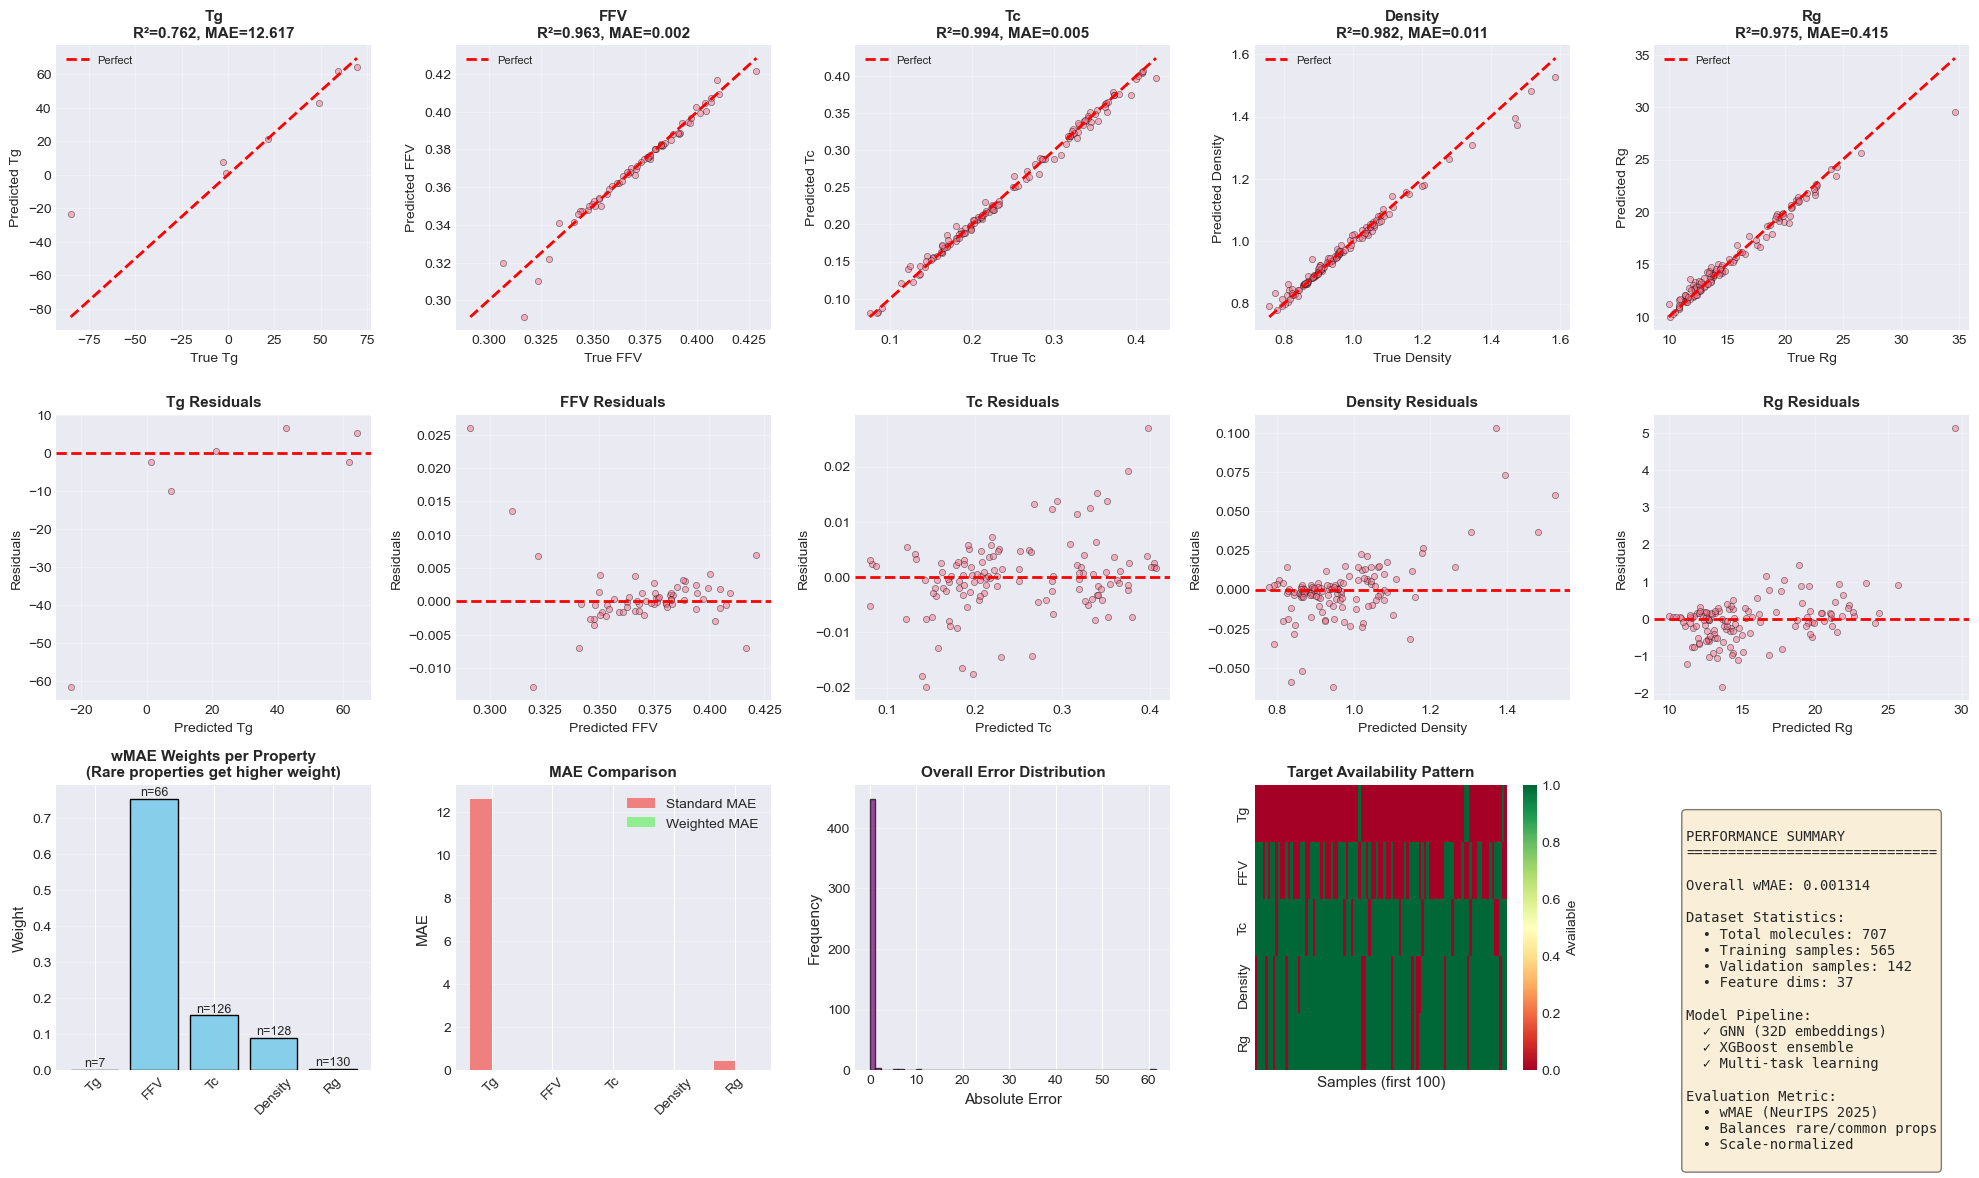


📊 Visualization complete!


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ================================================================
print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# ----------------------------------------------------------------
# 1. Prediction vs True Values (Scatter Plots)
# ----------------------------------------------------------------
print("   Creating scatter plots...")
for i, prop in enumerate(target_columns):
    ax = plt.subplot(3, 5, i + 1)
    
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        
        # Scatter plot
        ax.scatter(y_true, y_pred, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
        
        # Perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
        
        # Compute metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        ax.set_xlabel(f'True {prop}', fontsize=10)
        ax.set_ylabel(f'Predicted {prop}', fontsize=10)
        ax.set_title(f'{prop}\nR²={r2:.3f}, MAE={mae:.3f}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

# ----------------------------------------------------------------
# 2. Residual Plots
# ----------------------------------------------------------------
print("   Creating residual plots...")
for i, prop in enumerate(target_columns):
    ax = plt.subplot(3, 5, i + 6)
    
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        residuals = y_true - y_pred
        
        # Residual scatter
        ax.scatter(y_pred, residuals, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
        ax.axhline(y=0, color='r', linestyle='--', lw=2)
        
        ax.set_xlabel(f'Predicted {prop}', fontsize=10)
        ax.set_ylabel('Residuals', fontsize=10)
        ax.set_title(f'{prop} Residuals', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

# ----------------------------------------------------------------
# 3. Weight Visualization
# ----------------------------------------------------------------
print("   Creating weight visualization...")
ax = plt.subplot(3, 5, 11)

weights = [per_property_metrics[prop]['Weight'] for prop in target_columns if prop in per_property_metrics]
frequencies = [per_property_metrics[prop]['Frequency'] for prop in target_columns if prop in per_property_metrics]
props_list = [prop for prop in target_columns if prop in per_property_metrics]

bars = ax.bar(props_list, weights, color='skyblue', edgecolor='black')
ax.set_ylabel('Weight', fontsize=11)
ax.set_title('wMAE Weights per Property\n(Rare properties get higher weight)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

# Add frequency as text on bars
for bar, freq in zip(bars, frequencies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'n={freq}',
            ha='center', va='bottom', fontsize=9)

# ----------------------------------------------------------------
# 4. MAE Comparison (Standard vs Weighted)
# ----------------------------------------------------------------
print("   Creating MAE comparison...")
ax = plt.subplot(3, 5, 12)

mae_standard = [per_property_metrics[prop]['MAE'] for prop in target_columns if prop in per_property_metrics]
mae_weighted = [per_property_metrics[prop]['Weighted_MAE'] for prop in target_columns if prop in per_property_metrics]

x = np.arange(len(props_list))
width = 0.35

bars1 = ax.bar(x - width/2, mae_standard, width, label='Standard MAE', color='lightcoral')
bars2 = ax.bar(x + width/2, mae_weighted, width, label='Weighted MAE', color='lightgreen')

ax.set_ylabel('MAE', fontsize=11)
ax.set_title('MAE Comparison', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(props_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# ----------------------------------------------------------------
# 5. Error Distribution
# ----------------------------------------------------------------
print("   Creating error distribution...")
ax = plt.subplot(3, 5, 13)

all_errors = []
for i, prop in enumerate(target_columns):
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        errors = np.abs(y_true - y_pred)
        all_errors.extend(errors)

ax.hist(all_errors, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax.set_xlabel('Absolute Error', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Overall Error Distribution', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# ----------------------------------------------------------------
# 6. Data Availability Heatmap
# ----------------------------------------------------------------
print("   Creating availability heatmap...")
ax = plt.subplot(3, 5, 14)

# Sample availability across properties
availability_matrix = mask_val[:100]  # Show first 100 samples
sns.heatmap(availability_matrix.T, cmap='RdYlGn', cbar_kws={'label': 'Available'},
            yticklabels=target_columns, xticklabels=False, ax=ax)
ax.set_xlabel('Samples (first 100)', fontsize=11)
ax.set_title('Target Availability Pattern', fontsize=11, fontweight='bold')

# ----------------------------------------------------------------
# 7. Performance Summary
# ----------------------------------------------------------------
print("   Creating performance summary...")
ax = plt.subplot(3, 5, 15)
ax.axis('off')

summary_text = f"""
PERFORMANCE SUMMARY
{"="*30}

Overall wMAE: {wmae_score:.6f}

Dataset Statistics:
  • Total molecules: {len(X_combined)}
  • Training samples: {len(X_train)}
  • Validation samples: {len(X_val)}
  • Feature dims: {X_combined.shape[1]}

Model Pipeline:
  ✓ GNN (32D embeddings)
  ✓ XGBoost ensemble
  ✓ Multi-task learning

Evaluation Metric:
  • wMAE (NeurIPS 2025)
  • Balances rare/common props
  • Scale-normalized
"""

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../data/evaluation_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved visualization to: ../data/evaluation_results.png")
plt.show()

print("\n📊 Visualization complete!")


📊 DETAILED PER-PROPERTY ANALYSIS
✅ Saved detailed analysis to: ../data/per_property_analysis.png


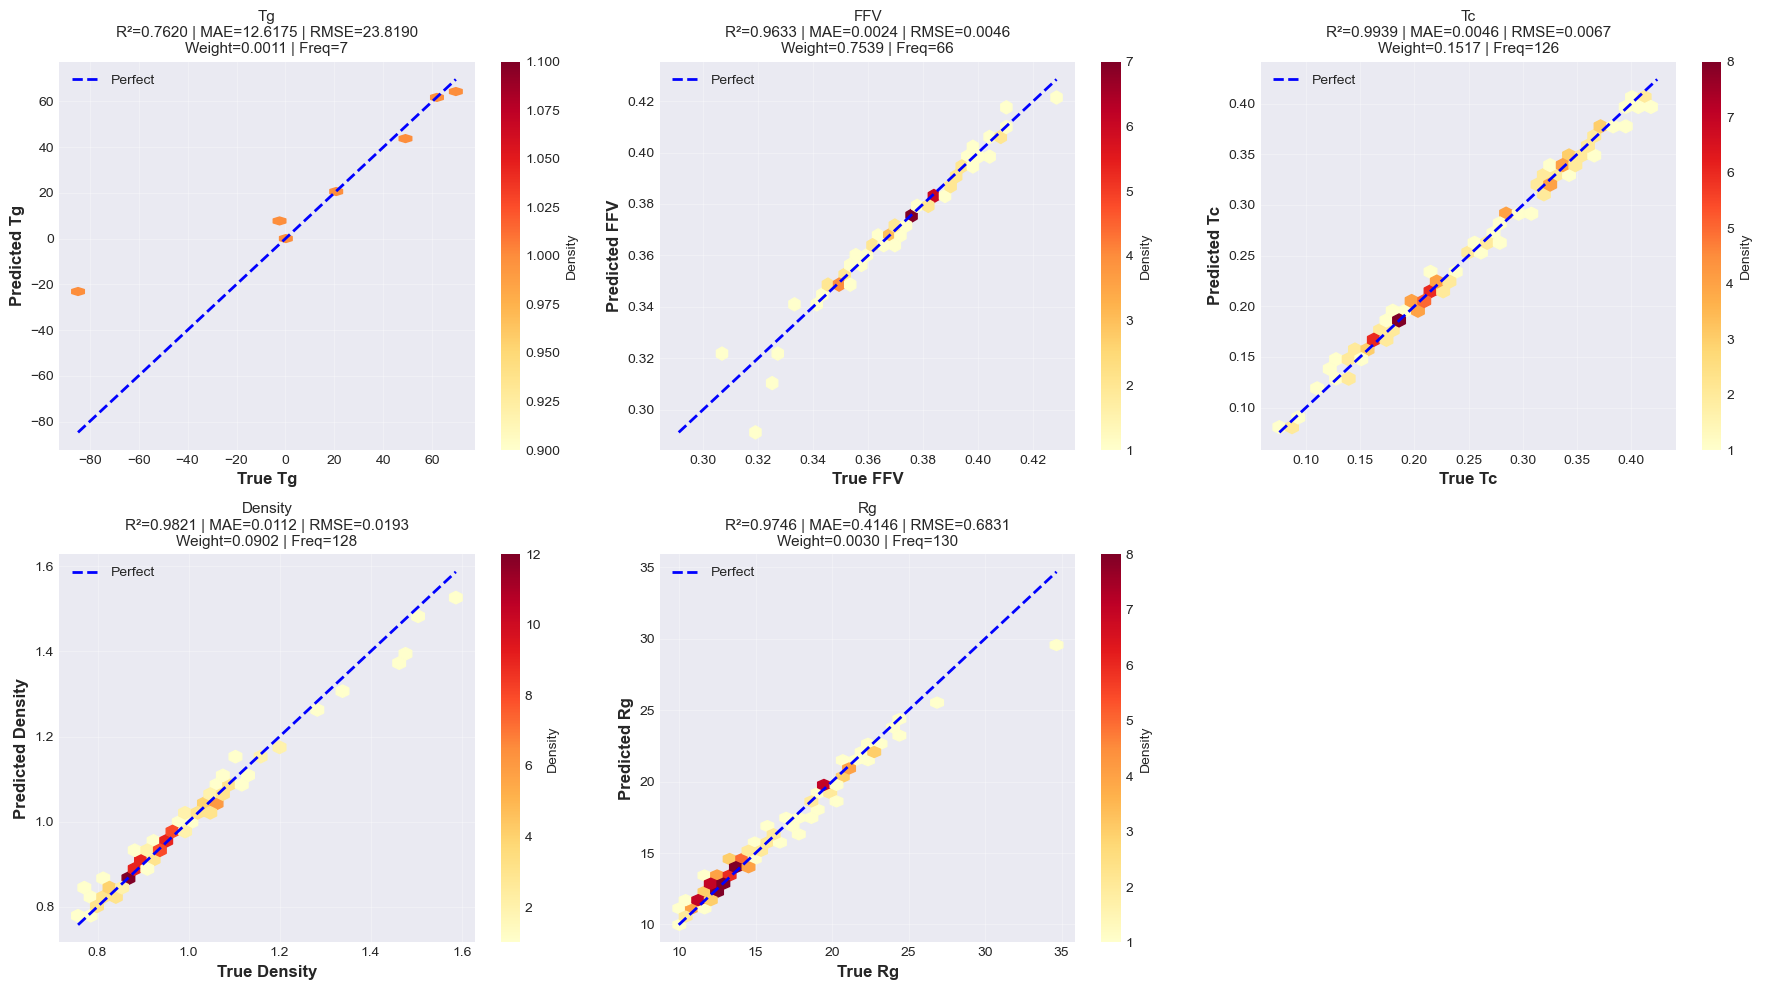

In [36]:
# ================================================================
print("\n" + "="*70)
print("📊 DETAILED PER-PROPERTY ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, prop in enumerate(target_columns):
    ax = axes[i]
    
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        
        # Create hexbin plot for density
        hb = ax.hexbin(y_true, y_pred, gridsize=30, cmap='YlOrRd', mincnt=1)
        
        # Perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'b--', lw=2, label='Perfect')
        
        # Compute detailed metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # Pearson correlation
        corr, _ = stats.pearsonr(y_true, y_pred)
        
        metrics = per_property_metrics[prop]
        
        ax.set_xlabel(f'True {prop}', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Predicted {prop}', fontsize=12, fontweight='bold')
        
        title_text = (f"{prop}\n"
                     f"R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}\n"
                     f"Weight={metrics['Weight']:.4f} | Freq={metrics['Frequency']}")
        ax.set_title(title_text, fontsize=11)
        
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(hb, ax=ax, label='Density')

# Hide extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('../data/per_property_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved detailed analysis to: ../data/per_property_analysis.png")
plt.show()

In [37]:
# ================================================================
print("\n" + "="*70)
print("📋 PREDICTION vs GROUND TRUTH COMPARISON")
print("="*70)

# Create comparison DataFrame
comparison_df = pd.DataFrame()

# Add predictions and ground truth for each property
for i, prop in enumerate(target_columns):
    mask_idx = mask_val[:, i] == 1
    
    if mask_idx.sum() > 0:
        # Create temporary DataFrame for this property
        temp_df = pd.DataFrame({
            f'{prop}_True': y_val[mask_idx, i],
            f'{prop}_Pred': y_val_pred[mask_idx, i],
            f'{prop}_Error': np.abs(y_val[mask_idx, i] - y_val_pred[mask_idx, i])
        })
        
        # Concatenate
        if comparison_df.empty:
            comparison_df = temp_df
        else:
            comparison_df = pd.concat([comparison_df, temp_df], axis=1)

# Display first 20 samples
print("\n📊 Sample Predictions (First 20 samples):")
print("="*70)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

display(comparison_df.head(20))

# Summary statistics
print("\n" + "="*70)
print("📈 PREDICTION STATISTICS:")
print("="*70)

for prop in target_columns:
    if f'{prop}_True' in comparison_df.columns:
        print(f"\n{prop}:")
        print(f"  True  - Mean: {comparison_df[f'{prop}_True'].mean():8.4f}, Std: {comparison_df[f'{prop}_True'].std():8.4f}")
        print(f"  Pred  - Mean: {comparison_df[f'{prop}_Pred'].mean():8.4f}, Std: {comparison_df[f'{prop}_Pred'].std():8.4f}")
        print(f"  Error - Mean: {comparison_df[f'{prop}_Error'].mean():8.4f}, Max: {comparison_df[f'{prop}_Error'].max():8.4f}")

# Save comparison
comparison_df.to_csv('../data/predictions_vs_groundtruth.csv', index=False)
print("\n✅ Saved to: ../data/predictions_vs_groundtruth.csv")


📋 PREDICTION vs GROUND TRUTH COMPARISON

📊 Sample Predictions (First 20 samples):


,Tg_True,Tg_Pred,Tg_Error,FFV_True,FFV_Pred,FFV_Error,Tc_True,Tc_Pred,Tc_Error,Density_True,Density_Pred,Density_Error,Rg_True,Rg_Pred,Rg_Error
0,49.3422,42.7232,6.6191,0.3760,0.3762,1.1741e-04,0.3440,0.3512,0.0072,0.8564,0.8611,0.0047,10.8609,10.8247,0.0362
1,59.5588,61.7153,2.1565,0.3885,0.3884,1.5922e-04,0.1530,0.1564,0.0034,0.8819,0.9442,0.0624,10.0591,9.9772,0.0819
2,21.7794,21.2398,0.5396,0.3873,0.3852,2.1087e-03,0.1220,0.1398,0.0178,0.9528,0.9738,0.0210,12.7117,12.7436,0.0319
3,-84.7223,-23.1492,61.5732,0.3918,0.3887,3.0655e-03,0.2075,0.2074,0.0001,0.8398,0.8435,0.0037,10.8787,11.0752,0.1964
4,-2.5267,7.3890,9.9157,0.3830,0.3821,9.5839e-04,0.2663,0.2614,0.0050,1.0171,1.0110,0.0061,11.4154,11.6654,0.2501
5,-0.8683,1.3384,2.2067,0.3764,0.3759,5.0858e-04,0.1980,0.1976,0.0004,0.8114,0.8053,0.0061,13.0580,13.6706,0.6126
6,69.5749,64.2634,5.3115,0.3575,0.3591,1.5249e-03,0.1975,0.1957,0.0018,1.1171,1.1102,0.0068,12.0505,11.8802,0.1703
7,NaN,NaN,NaN,0.3512,0.3498,1.4524e-03,0.2267,0.2194,0.0073,1.0599,1.0455,0.0144,11.3441,11.4592,0.1150
8,NaN,NaN,NaN,0.3701,0.3662,3.8870e-03,0.1990,0.1940,0.0050,1.1628,1.1507,0.0121,16.5522,15.9913,0.5609
9,NaN,NaN,NaN,0.3825,0.3829,4.0455e-04,0.1635,0.1626,0.0009,0.8033,0.7998,0.0034,11.5752,11.5489,0.0262



📈 PREDICTION STATISTICS:

Tg:
  True  - Mean:  16.0197, Std:  52.7344
  Pred  - Mean:  25.0743, Std:  32.6757
  Error - Mean:  12.6175, Max:  61.5732

FFV:
  True  - Mean:   0.3720, Std:   0.0242
  Pred  - Mean:   0.3714, Std:   0.0248
  Error - Mean:   0.0024, Max:   0.0260

Tc:
  True  - Mean:   0.2470, Std:   0.0866
  Pred  - Mean:   0.2470, Std:   0.0845
  Error - Mean:   0.0046, Max:   0.0269

Density:
  True  - Mean:   0.9677, Std:   0.1445
  Pred  - Mean:   0.9679, Std:   0.1321
  Error - Mean:   0.0112, Max:   0.1033

Rg:
  True  - Mean:  15.4878, Std:   4.3032
  Pred  - Mean:  15.5170, Std:   3.9380
  Error - Mean:   0.4146, Max:   5.1222

✅ Saved to: ../data/predictions_vs_groundtruth.csv
